""" Rb Raman pulse scan
    Preston Huft, May 2019    
"""

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import complex_ode,odeint
from scipy.integrate import solve_ivp
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time
from math import pi,sqrt

In [2]:
## physical constants
e = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 3e8 # [m]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]

In [14]:
###############################################################################
## METHODS and GLOBAL PARAMETERS
###############################################################################

## Methods

def cc(z): 
    return np.conj(z)  


def Intensity(P,w0,r,A=None,r0=None):
    """ Gaussian beam intensity at radius 'r' for
        'P' power
        'w0' beam waist
        'A' area
    """
    if r0 is None:
        r0 = 0
    if A is None:
        A = pi*w0**2
    
    return (P/A)*np.exp(-(r-r0)**2/(2*w0**2))

def z_rayleigh(w0,wl):
    return (pi*w0**2)/wl

def g_waist(z,w0,zR):
    return w0*sqrt(1+(z/zR)**2)  

## "GLOBAL" VARIABLES (scope excludes method bodies)

lmbda = 7.8e-7 # [m] wavelength
o1DipoleElem = -1.792e-29 # see rb_matrix_elements
o2DipoleElem = 1.792e-29

In [13]:
## Build an array of Rabi frequencies for varied beam location wrt center site

## experiment parameters and pertinent quantities
P = 2*(3.5e-6) # [W] beam power per sideband at atoms
w0 = 6e-6 # [m] expected Gaussian beam waist at atoms
D = 2*pi*(4.5e10) # [Hz] single-photon detuning

a = 6e-6 # [m] w0 in x direction
b = 8e-6 # [m] w0 in y direction
A = a*b*pi # area at beam waist 

# Rabi frequencies and the position values to be scanned
r_vals = np.linspace(-15e-6,15e-6,13) # the positions to scan
O_vals = (2/(c*e0*hbar**2))*Intensity(P,w0,r_vals,A,r0=None) \
        *o1DipoleElem*o2DipoleElem \
        /(2*D)

print([O/(2*pi*1e6) for O in O_vals])

[-0.012480102193402955, -0.03242717035538863, -0.07082745178269606, -0.1300456511470099, -0.20072048718844038, -0.2604289282948177, -0.28404581667834394, -0.2604289282948176, -0.20072048718844027, -0.13004565114700986, -0.07082745178269602, -0.03242717035538863, -0.012480102193402955]


In [16]:
## Build an array of areas for different distances on the optical axis from the focus

w0y = 6e-6 # [m] w0 in x direction
w0x = 8e-6 # [m] w0 in y direction
# A = w0x*w0y*pi # area at beam waist 

zRx = z_rayleigh(w0x,lmbda) 
zRy = z_rayleigh(w0y,lmbda) # this is the shorter zR

z_vals = np.linspace(0,zRy,5)

x_waists = np.array([g_waist(z,w0x,zRx) for z in z_vals])

# different beam areas to try in the simulation
A_vals = np.array([pi*g_waist(z,w0x,zRx)*g_waist(z,w0y,zRy) for z in z_vals])
print(A_vals)

[1.50796447e-10 1.56966814e-10 1.75136746e-10 2.04583125e-10
 2.44681467e-10]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


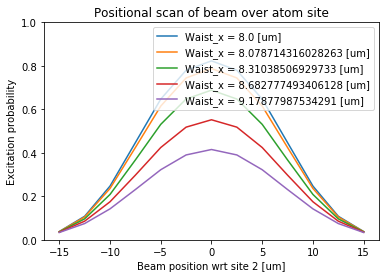

In [9]:
###############################################################################
## Rabi oscillations with no spontaneous emission, for various values
## of detuning from the transition resonance
###############################################################################

def derivs(y0,t,t1,t2,D,O):
# def derivs(t,y0,params):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    rgg,ree,reg = y0
#     O,D,t1,t2 = params # Rabi freq,detuning,lifetime,coherence
    
    # time derivatives of density op elements
    curl = 1j/2*(O*cc(reg)-cc(O)*reg) 
    drgg = ree/t1 - curl 
    dree = -ree/t1 + curl
    dreg = (1j*D-1/(2*t1))*reg+1j*O/2*(rgg-ree) # = cc(drge)
    
    return np.array([drgg,dree,dreg])

## initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.


## Dipole matrix elements
o1DipoleElem = -1.792e-29 # see rb_matrix_elements
o2DipoleElem = 1.792e-29

## experiment parameters and pertinent quantities
P = 2*(3.5e-6) # [W] beam power per sideband at atoms
w0 = 6e-6 # [m] expected Gaussian beam waist at atoms
D = 2*pi*(4.5e10) # [Hz] single-photon detuning

A = a*b*pi # area at beam waist 


# Rabi frequencies and the position values to be scanned
r_vals = np.linspace(-15e-6,15e-6,13) # the positions to scan
O_vals = (2/(c*e0*hbar**2))*Intensity(P,w0,r_vals,A,r0=None) \
        *o1DipoleElem*o2DipoleElem \
        /(2*D)
# # beam position values to be scanned
# r_vals = np.linspace(-15e-6,15e-6,13) # the positions to scan
# # O_vals = (2/(c*e0*hbar**2))*Intensity(P,w0,r_vals,A,r0=None) \
# #         *o1DipoleElem*o2DipoleElem \
# #         /(2*D)
# # A = 6e-6*8e-6*pi

# equation parameters
t1 = np.inf # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence 

# experiment duration
t_exp = 8 # [us]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_ylabel('Excitation probability')

retention = np.empty(len(r_vals))

for wx,A in zip(x_waists,A_vals):
    O_vals = (2/(c*e0*hbar**2))*Intensity(P,wx,r_vals,A,r0=None) \
            *o1DipoleElem*o2DipoleElem \
            /(2*D)

    Det = 0 # detuning
    for i,O in enumerate(O_vals/(2*pi*1e6)): # iterate over Rabi freq. vals 
        func = lambda y,t: derivs(t,y,t1,t2,Det,O)
        soln = solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50))
        retention[i]=soln.y[1][-1]
    ax.set_title('Positional scan of beam over atom site')
    ax.set_xlabel('Beam position wrt site 2 [um]')    
    ax.plot(r_vals*1e6,retention,label=f"Waist_x = {wx/1e-6} [um]")

ax.legend(loc='upper right')
plt.show()

In [26]:
## Build an array of areas for different distances on the optical axis from the focus

w0y = 6e-6 # [m] w0 in x direction
w0x = 6e-6 # [m] w0 in y direction
# A = w0x*w0y*pi # area at beam waist 

zRx = z_rayleigh(w0x,lmbda) 
zRy = z_rayleigh(w0y,lmbda) # this is the shorter zR

z_vals = np.linspace(0,zRy,5)

x_waists = np.array([g_waist(z,w0x,zRx) for z in z_vals])

# different beam areas to try in the simulation
A_vals = np.array([pi*g_waist(z,w0x,zRx)*g_waist(z,w0y,zRy) for z in z_vals])
print(A_vals)

[1.13097336e-10 1.20165919e-10 1.41371669e-10 1.76714587e-10
 2.26194671e-10]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


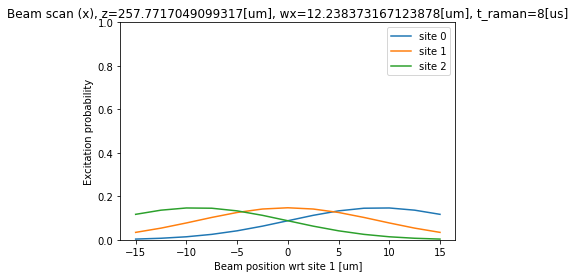

In [46]:
###############################################################################
## Raman 8 us pulse beam position scan for three atom sights
###############################################################################

def derivs(y0,t,t1,t2,D,O):
# def derivs(t,y0,params):
    """ Returns RHS of optical bloch eqs for current values at time t"""
    rgg,ree,reg = y0
#     O,D,t1,t2 = params # Rabi freq,detuning,lifetime,coherence
    
    # time derivatives of density op elements
    curl = 1j/2*(O*cc(reg)-cc(O)*reg) 
    drgg = ree/t1 - curl 
    dree = -ree/t1 + curl
    dreg = (1j*D-1/(2*t1))*reg+1j*O/2*(rgg-ree) # = cc(drge)
    
    return np.array([drgg,dree,dreg])

## initial conditions - system starts in ground state
rho_ee = 0 + 0j
rho_gg = 1 + 0j
rho_eg = 0 + 0j # no initial mixing; this is actually rho^tilda_ge
y0 = np.array([rho_gg,rho_ee,rho_eg]) # bundle i.c.

## empirical parameters and pertinent quantities
P = 2*(3.5e-6) # [W] beam power per sideband at atoms
D = 2*pi*(4.5e10) # [Hz] single-photon detuning

## OBE parameters
t1 = np.inf # upper state lifetime (1/gamma)
t2 = np.inf # atomic coherence
Det = 0 # detuning from |e> in two level picture

# experiment lists/variables 
r_vals = np.linspace(-15e-6,15e-6,13) # the positions to scan 
sites = 3 # number of atom sites
D_arr = [0,0,0] # site-specific detuning due to different trap depths
spacing = 9e-6 # [m] spacing between atom sights in x direction
dr = [-spacing,0,spacing]
retention = []

t_exp = 8 # [us] # raman pulse duration

## Build beam waist and area arrays:
w0x = 6e-6 # [m] w0 in x direction
w0y = 8e-6 # [m] w0 in y direction
zRx = z_rayleigh(w0x,lmbda) 
zRy = z_rayleigh(w0y,lmbda)

z_vals = np.linspace(0,zRy,4) 
x_waists = np.array([g_waist(z,w0x,zRx) for z in z_vals])
A_vals = np.array([pi*g_waist(z,w0x,zRx)*g_waist(z,w0y,zRy) for z in z_vals])

z=3 # 0 is at focus, -1 is at Rayleigh range
wx = x_waists[z] # waist at x
A = A_vals[z] # area at z=0

## initialize the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_ylim((0,1))
ax.set_ylabel('Excitation probability')

for s in range(0,sites): # iterate over the sites

    O_vals = (2/(c*e0*hbar**2))*Intensity(P,wx,r_vals+dr[s],A,r0=None) \
        *o1DipoleElem*o2DipoleElem \
        /(2*(D+D_arr[s]))
    
    retention.append(np.empty(len(r_vals)))
    for i,O in enumerate(O_vals/(2*pi*1e6)): # iterate over Rabi freq. vals 
        func = lambda y,t: derivs(t,y,t1,t2,Det,O)
        soln = solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50))
        retention[s][i]=soln.y[1][-1]
    ax.set_title('Positional scan of beam over atom site')
    ax.set_xlabel('Beam position wrt site 1 [um]')    
    ax.plot(r_vals*1e6,retention[s],label=f"site {s}")

ax.set_title(f'Beam scan (x), z={z_vals[z]/1e-6}[um], wx={wx/1e-6}[um], t_raman={t_exp}[us]')
ax.legend(loc='upper right')
plt.show()

In [39]:
z_vals

array([0.00000000e+00, 6.44429262e-05, 1.28885852e-04, 1.93328779e-04,
       2.57771705e-04])

In [43]:
zRx

0.0001449965840118366